# Wind Data From NOAA's Rapid Refresh
---

**NOAA**: National Oceanic and Atmospheric Administration

**RAP**: Rapid Refresh  
Information can be found at the following url:
https://www.ncdc.noaa.gov/data-access/model-data/model-datasets/rapid-refresh-rap

Data can be retrieved using the NetCDF Subset Service (NCSS). Information on this protocol are available at: https://www.unidata.ucar.edu/software/thredds/current/tds/reference/NetcdfSubsetServiceReference.html

The Rapid Refresh (RAP) numerical weather model is run by the National Centers for Environmental Prediction (NCEP), which is part of of the NOAA. Multiple data sources go into the generation of RAP model: commercial aircraft weather data, balloon data, radar data, surface observations, and satellite data. The model generates data down to a 13x13 squre kilometer resolution grid every hour. 

In [1]:
from westernintnet.westernintnet import WesternIntNet
import sys

sys.path.append("../")

import rap
import impute
import pandas as pd
from matplotlib import pyplot
from helpers import to_reise

## 1. Wind Farms in Network

In [2]:
grid = WesternIntNet()
wind_farm = grid.genbus.groupby('type').get_group('wind')

Loading sub
Loading bus2sub
Loading bus
Loading genbus
Loading branches
Loading resources
Loading net_generation
Load solar data
Load wind data
Load hydro data
Load demand data
Done loading


In [3]:
wind_farm.head()

,busID,Pg,Qg,Qmax,Qmin,Vg,mBase,status,Pmax,Pmin,...,mu_Qmax,mu_Qmin,type,lat,lon,GenMWMax,GenMWMin,AreaNum,ZoneName,base_color
plantID,,,,,,,,,,,,,,,,,,,,,
7,10691,59.72,21.07,21.07,-14.24,1.0063,98.92,1,59.72,59.72,...,0.0,0.0000;,wind,45.813100,-120.347500,98.900002,16.648942,1,Washington,#15b01a
10,10699,79.42,-14.50,21.45,-14.50,1.0019,120.64,1,79.42,79.42,...,0.0,0.0000;,wind,47.135600,-120.687200,100.699997,13.150001,1,Washington,#15b01a
11,10703,136.30,25.92,29.03,-19.63,1.0605,174.64,1,136.30,136.30,...,0.0,0.0000;,wind,45.879700,-120.807200,136.300004,43.062568,1,Washington,#15b01a
38,10746,66.35,-12.96,19.17,-12.96,1.0205,98.26,1,66.35,66.35,...,0.0,0.0000;,wind,46.954700,-120.181900,89.999998,19.930001,1,Washington,#15b01a
52,10768,212.51,56.83,56.83,-38.42,1.0304,301.55,1,212.51,212.51,...,0.0,0.0000;,wind,46.421111,-118.026944,266.799998,122.148347,1,Washington,#15b01a


In [4]:
print("There are %d wind farms in the Western grid." % len(wind_farm))

There are 243 wind farms in the Western grid.


## 2. Downloading Data from NCEP's Server
Only few days are considered here. Note that some files on the server may be missing.

In [5]:
data, missing = rap.retrieve_data(wind_farm, start_date='2016-01-01', end_date='2016-01-10')

100%|████████████████████████████████████████████████████████████████████████████████| 240/240 [11:16<00:00,  2.82s/it]


In [6]:
print("There are %d missing files." % len(missing))

There are 33 missing files.


In [7]:
data.head()

,plantID,U,V,Pout,ts,tsID
0,7,-6.482498,-3.10574,33.909546,2016-01-01,1
1,10,-5.482498,5.89426,48.626080,2016-01-01,1
2,11,-6.982498,-2.48074,51.586488,2016-01-01,1
3,38,-6.357498,-1.60574,23.288450,2016-01-01,1
4,52,-2.732498,-3.98074,24.722452,2016-01-01,1


## 3. Plot Data
One wind farm is selected. The U and V components of the wind speed (in m/s) 80-m above ground along with the power output (in MW) are then plotted. One can see the missing data. Note that there are 242 files (hour equivalent) missing in 2016.

In [8]:
data_oneplant = data[data.plantID == 38]

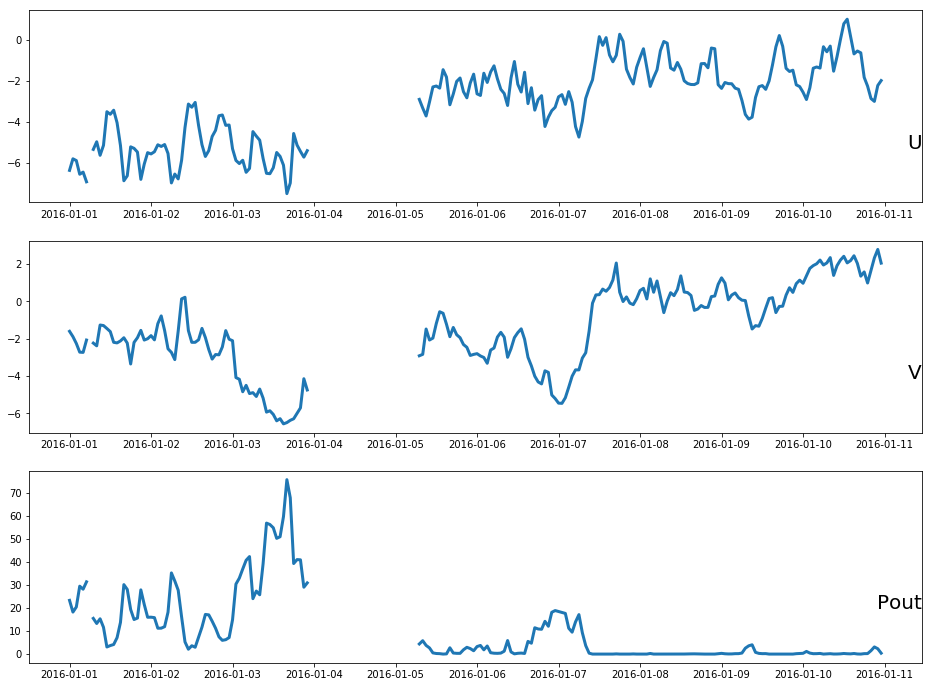

In [9]:
pyplot.figure(figsize=(16,12))
for i, var in enumerate(['U','V','Pout']):
    pyplot.subplot(3,1,i+1)
    pyplot.plot(data_oneplant['ts'], data_oneplant[var], lw=3)
    pyplot.title(var, y=0.25, loc='right', fontsize=20)

## 4. Impute Missing Data
The missing data are imputed inplace using a simple procedure. The plot below shows the imputed data.

In [10]:
impute.simple(data, wind_farm, inplace=True)

100%|█████████████████████████████████████████████████████████████████████████████| 8019/8019 [00:28<00:00, 282.17it/s]


In [11]:
data_impute_oneplant = data[data.plantID == 38]

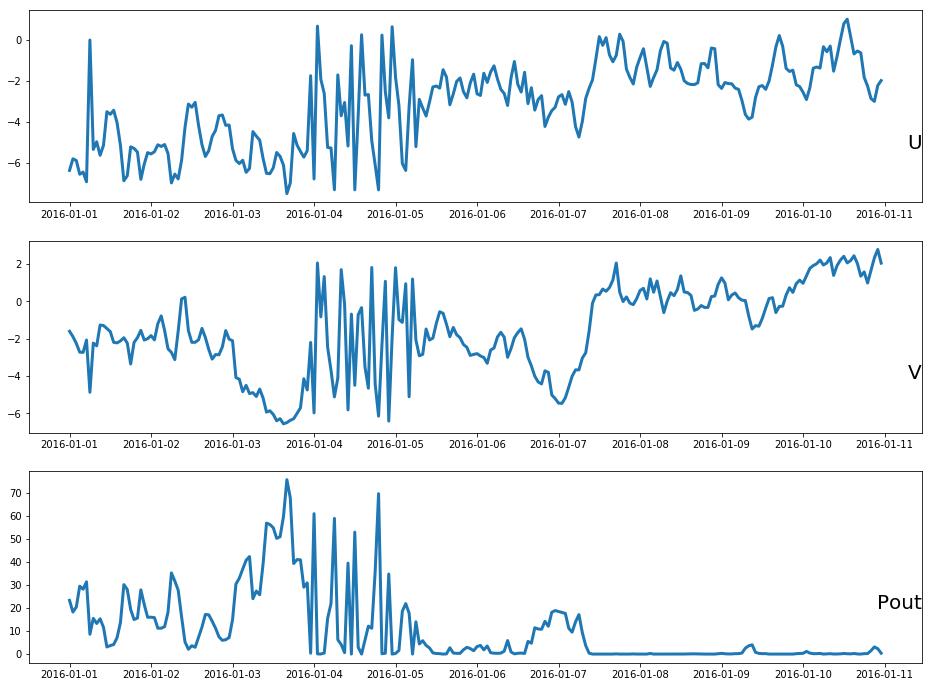

In [12]:
pyplot.figure(figsize=(16,12))
for i, var in enumerate(['U','V','Pout']):
    pyplot.subplot(3,1,i+1)
    pyplot.plot(data_impute_oneplant['ts'], data_impute_oneplant[var], lw=3)
    pyplot.title(var, y=0.25, loc='right', fontsize=20)

## 5. Format Data
Data are formated for REISE.

In [13]:
data_reise = to_reise(data)

In [14]:
data_reise.head()

,7,10,11,38,52,68,73,85,132,151,...,2391,2404,2405,2406,2420,2421,2431,2432,2461,2463
UTC,,,,,,,,,,,,,,,,,,,,,
2016-01-01 00:00:00,33.909546,48.626080,51.586488,23.288450,24.722452,2.797636,30.861675,39.982030,19.645964,25.497791,...,1.537407,104.988481,9.695788,9.595831,4.768569,5.298409,7.203523,7.203523,102.031051,187.616487
2016-01-01 01:00:00,44.784148,36.054589,57.629619,18.203596,13.542212,6.911965,39.535177,39.244850,18.829837,31.653611,...,3.845821,106.481712,9.696933,9.596964,8.460214,9.400238,8.365460,8.365460,103.482219,188.972294
2016-01-01 02:00:00,40.734996,18.561881,52.191783,20.425524,16.816121,11.194243,39.297413,24.722842,16.544856,27.673932,...,3.740176,106.496834,9.698210,9.598228,8.983049,9.981165,9.284972,9.284972,103.496915,188.999999
2016-01-01 03:00:00,50.635387,20.275974,73.058373,29.439972,4.268782,10.527046,49.774332,43.521291,23.969048,32.047304,...,5.370021,106.500006,9.696742,9.596776,8.999180,9.999089,9.952833,9.952833,103.499997,188.999999
2016-01-01 04:00:00,53.228489,9.405172,84.871384,28.126471,0.725327,7.316950,55.562933,45.677556,27.052540,34.383732,...,9.226200,106.500006,9.666699,9.567042,8.980537,9.978374,9.972236,9.972236,103.499997,188.999999
